In [1]:
import pyomo.environ as oe
import pandas as pd
from pyomo.opt import SolverFactory
from subproblem_model import build_subproblem_model
from subproblem_dataloader import DataLoader

In [2]:
data = DataLoader()

In [3]:
#display(data.BMPGRPING)
#display(data.BMPGRPING)

In [4]:
# Note that there is no need to call create_instance on a ConcreteModel
mdl = build_subproblem_model(pltnts=data.PLTNTS,
                             lrsegs=data.LRSEGS,
                             bmps=data.BMPS,
                             bmpgrps=data.BMPGRPS,
                             bmpgrping=data.BMPGRPING,
                             loadsrcs=data.LOADSRCS,
                             bmpsrclinks=data.BMPSRCLINKS,
                             bmpgrpsrclinks=data.BMPGRPSRCLINKS,
                             c=data.c,
                             e=data.E,
                             tau=data.tau,
                             phi=data.phi,
                             t=data.T)

In [29]:
solver = SolverFactory("minos")
results = solver.solve(mdl, tee=True, symbolic_solver_labels=True)

print('Objective is:')
print(mdl.Total_Cost())

# instance.solutions.store_to(results)
print(results)

MINOS 5.51Objective is:
842698.0542672966

Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 1110
  Number of variables: 1339
  Sense: unknown
Solver: 
- Status: ok
  Message: MINOS 5.51\x3a optimal solution found.; 34 iterations, objective 842698.0542633871; Nonlin evals\x3a constrs = 39, Jac = 38.
  Termination condition: optimal
  Id: 0
  Error rc: 0
  Time: 0.05178189277648926
Solution: 
- number of solutions: 0
  number of solutions displayed: 0



In [62]:
# Extract just the nonzero optimal variable values
tol = 1e-6
nzvarnames = []
nzvarvalus = []
for k in mdl.x.keys():
    if (not not mdl.x[k].value):
        if abs(mdl.x[k].value)>tol:
            nzvarnames.append(mdl.x[k].getname())
            nzvarvalus.append(mdl.x[k].value)
            
# Repeat the same thing, but make a DataFrame
nonzerokeyvals_df = pd.DataFrame([[k, mdl.x[k].value]
                                  for k in mdl.x.keys()
                                  if (not not mdl.x[k].value) 
                                  if abs(mdl.x[k].value)>tol],
                                 columns=['key', 'value'])
display(nonzerokeyvals_df.head(2))

nonzerodf = pd.DataFrame.from_dict([{'bmpshortname':x[0],
                                     'landriversegment':x[1],
                                     'loadsource': x[2],
                                     'acres': y}
                                    for x, y in zip(nonzerokeyvals_df.key, nonzerokeyvals_df.value)])
display(nonzerodf.head(2))

,key,value
0,"(DitchFilter, N51133RL0_6450_0000, pas)",423.264709
1,"(IncorpLowEarly, N51133RL0_6450_0000, dbl)",3524.195312


,acres,bmpshortname,landriversegment,loadsource
0,423.264709,DitchFilter,N51133RL0_6450_0000,pas
1,3524.195312,IncorpLowEarly,N51133RL0_6450_0000,dbl


In [7]:
mdl.x['HRTill', 'N51133RL0_6450_0000', 'oac'].value

259.9378662109375

In [8]:
tol = 1e-6
for b in mdl.BMPS:
    for lmbda in mdl.LOADSRCS:
        bval = mdl.x[b, 'N51133RL0_6450_0000', lmbda].value
        if not not bval:
            if abs(bval)>tol:
                print('(%s, %s): %d' % (b, lmbda, bval))

(DitchFilter, pas): 423
(IncorpLowEarly, dbl): 3524
(CoverCropTradRED, gom): 782
(ConPlan, pas): 423
(HRTill, oac): 259
(HRTill, gom): 3629
(HRTill, scl): 18
(HRTill, sch): 13
(HRTill, soy): 1631
(HRTill, gwm): 796
(HRTill, sgg): 149
(HRTill, dbl): 3524
(UrbanNMPlanHR, ntg): 2834
(UrbanNMPlanHR, mcn): 32
(UrbanNMPlanHR, nch): 2023
(WetPondWetland, ntg): 1914


In [15]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


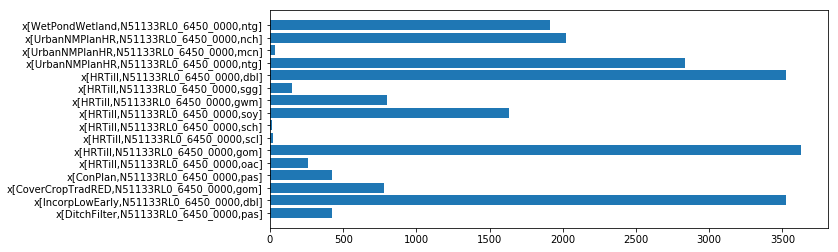

In [63]:
from matplotlib import pyplot as plt
# barh(range(len(res)),res.values(), align='center')
fig = plt.figure(figsize=(10, 4))
rects = plt.barh(y=nzvarnames, width=nzvarvalus)
ax = plt.gca()
# ax.tick_params(axis='x', colors='white')

In [64]:
# add cost/unit data to results table
costsubtbl = data.costsubtbl
# Retain only those costs pertaining to bmps in our set
includecols = ['totalannualizedcostperunit', 'bmpshortname']
nonzerodf = nonzerodf.merge(costsubtbl.loc[:,includecols])
display(nonzerodf.head(2))

# Add total cost of each BMP to results table for this instance
nonzerodf['totalinstancecost'] = np.multiply(nonzerodf['totalannualizedcostperunit'].values,
                                             nonzerodf['acres'].values)
display(nonzerodf.head(2))
coststrs = [str(x) for x in zip(list(nonzerodf['totalannualizedcostperunit']),
                                list(nonzerodf['totalinstancecost']))]
display(coststrs)

,acres,bmpshortname,landriversegment,loadsource,totalannualizedcostperunit
0,423.264709,DitchFilter,N51133RL0_6450_0000,pas,10.05
1,3524.195312,IncorpLowEarly,N51133RL0_6450_0000,dbl,17.34


,acres,bmpshortname,landriversegment,loadsource,totalannualizedcostperunit,totalinstancecost
0,423.264709,DitchFilter,N51133RL0_6450_0000,pas,10.05,4253.810330
1,3524.195312,IncorpLowEarly,N51133RL0_6450_0000,dbl,17.34,61109.546719


['(10.05, 4253.8103302001955)',
 '(17.34, 61109.546718749996)',
 '(68.94, 53928.91728647074)',
 '(1.94, 821.1335363769531)',
 '(0.0, 0.0)',
 '(0.0, 0.0)',
 '(0.0, 0.0)',
 '(0.0, 0.0)',
 '(0.0, 0.0)',
 '(0.0, 0.0)',
 '(0.0, 0.0)',
 '(0.0, 0.0)',
 '(0.0, 0.0)',
 '(0.0, 0.0)',
 '(0.0, 0.0)',
 '(377.47, 722584.6463954985)']

In [67]:
data.tau

{('N51133RL0_6450_0000', 'N'): 7,
 ('N51133RL0_6450_0000', 'P'): 7,
 ('N51133RL0_6450_0000', 'S'): 7}

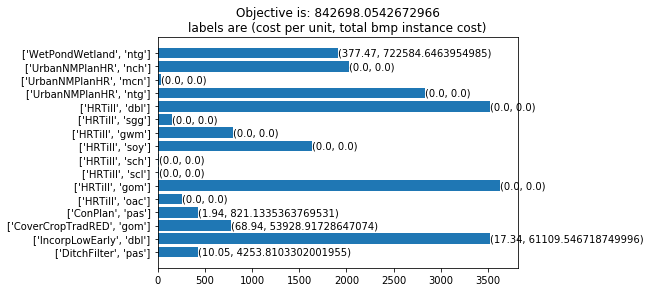

In [66]:
from datetime import datetime
keystrs = [str([x, y]) for x, y in zip(nonzerodf['bmpshortname'], nonzerodf['loadsource'])]

# Make Figure
fig = plt.figure(figsize=(10, 4))
rects = plt.barh(y=keystrs, width=nonzerodf['acres'])
ax = plt.gca()

for rect, label in zip(rects, coststrs):
    width = rect.get_width()
    plt.text(width + 0.1, rect.get_y() + rect.get_height() / 2, label,
            ha='left', va='center')

objstr = ''.join(['Objective is: ', str(mdl.Total_Cost())])
labelstr = 'labels are (cost per unit, total bmp instance cost)'
plt.title('\n'.join([objstr, labelstr]))

ax.set_position([0.3,0.1,0.5,0.8])
#plt.tight_layout()


#plt.savefig(os.path.join(projectpath,''.join(['output/tau19N19P19S_minos_', datetime.now().strftime('%Y-%m-%d_%H%M%S'),'.png'])))